In [2]:
import pandas as pd

# question 1 
# Load the original data 
jan23 = pd.read_csv("data/nyc_crashes_202301.csv")

In [10]:
# Create a new column that indicates whether there is missing geocode or not
jan23['Missing Geocode'] = jan23['LATITUDE'].isna() | jan23['LONGITUDE'].isna()

# Create a contingency table for missing geocode by borough
contingency_table = pd.crosstab(jan23['BOROUGH'], jan23['Missing Geocode'], margins=True)

print(contingency_table)

Missing Geocode  False  True   All
BOROUGH                           
BRONX              797    13   810
BROOKLYN          1630    13  1643
MANHATTAN          788    16   804
QUEENS            1291    16  1307
STATEN ISLAND      191     3   194
All               4697    61  4758


In [33]:
# The null hypothesis is that the proportion of missing geocodes is the same across boroughs.
import scipy.stats
from scipy.stats import chi2_contingency

# Using chi-squared test of independence to test the hypothesis.
chi2, p, dof, expected = chi2_contingency(contingency_table)

# The p-value is more than 0.05, we could not reject the null hypothesis. 
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 7.120605175803308
P-value: 0.714012148192199


In [35]:
# question 2 
# Load the cleaned data 
jan23c = pd.read_csv("data/nyc_crashes_cleaned.csv")

In [36]:
# Construct a hour variable with integer values from 0 to 23
jan23c['hour'] = pd.to_datetime(jan23c['CRASH TIME']).dt.hour

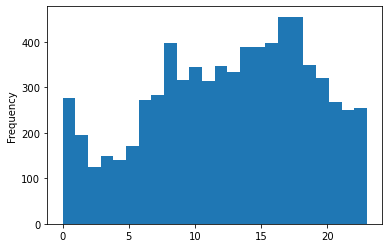

In [39]:
import matplotlib.pyplot as plt

# Plot the histogram of the number of crashes by hour
jan23c['hour'].plot.hist(bins=24)
plt.show()

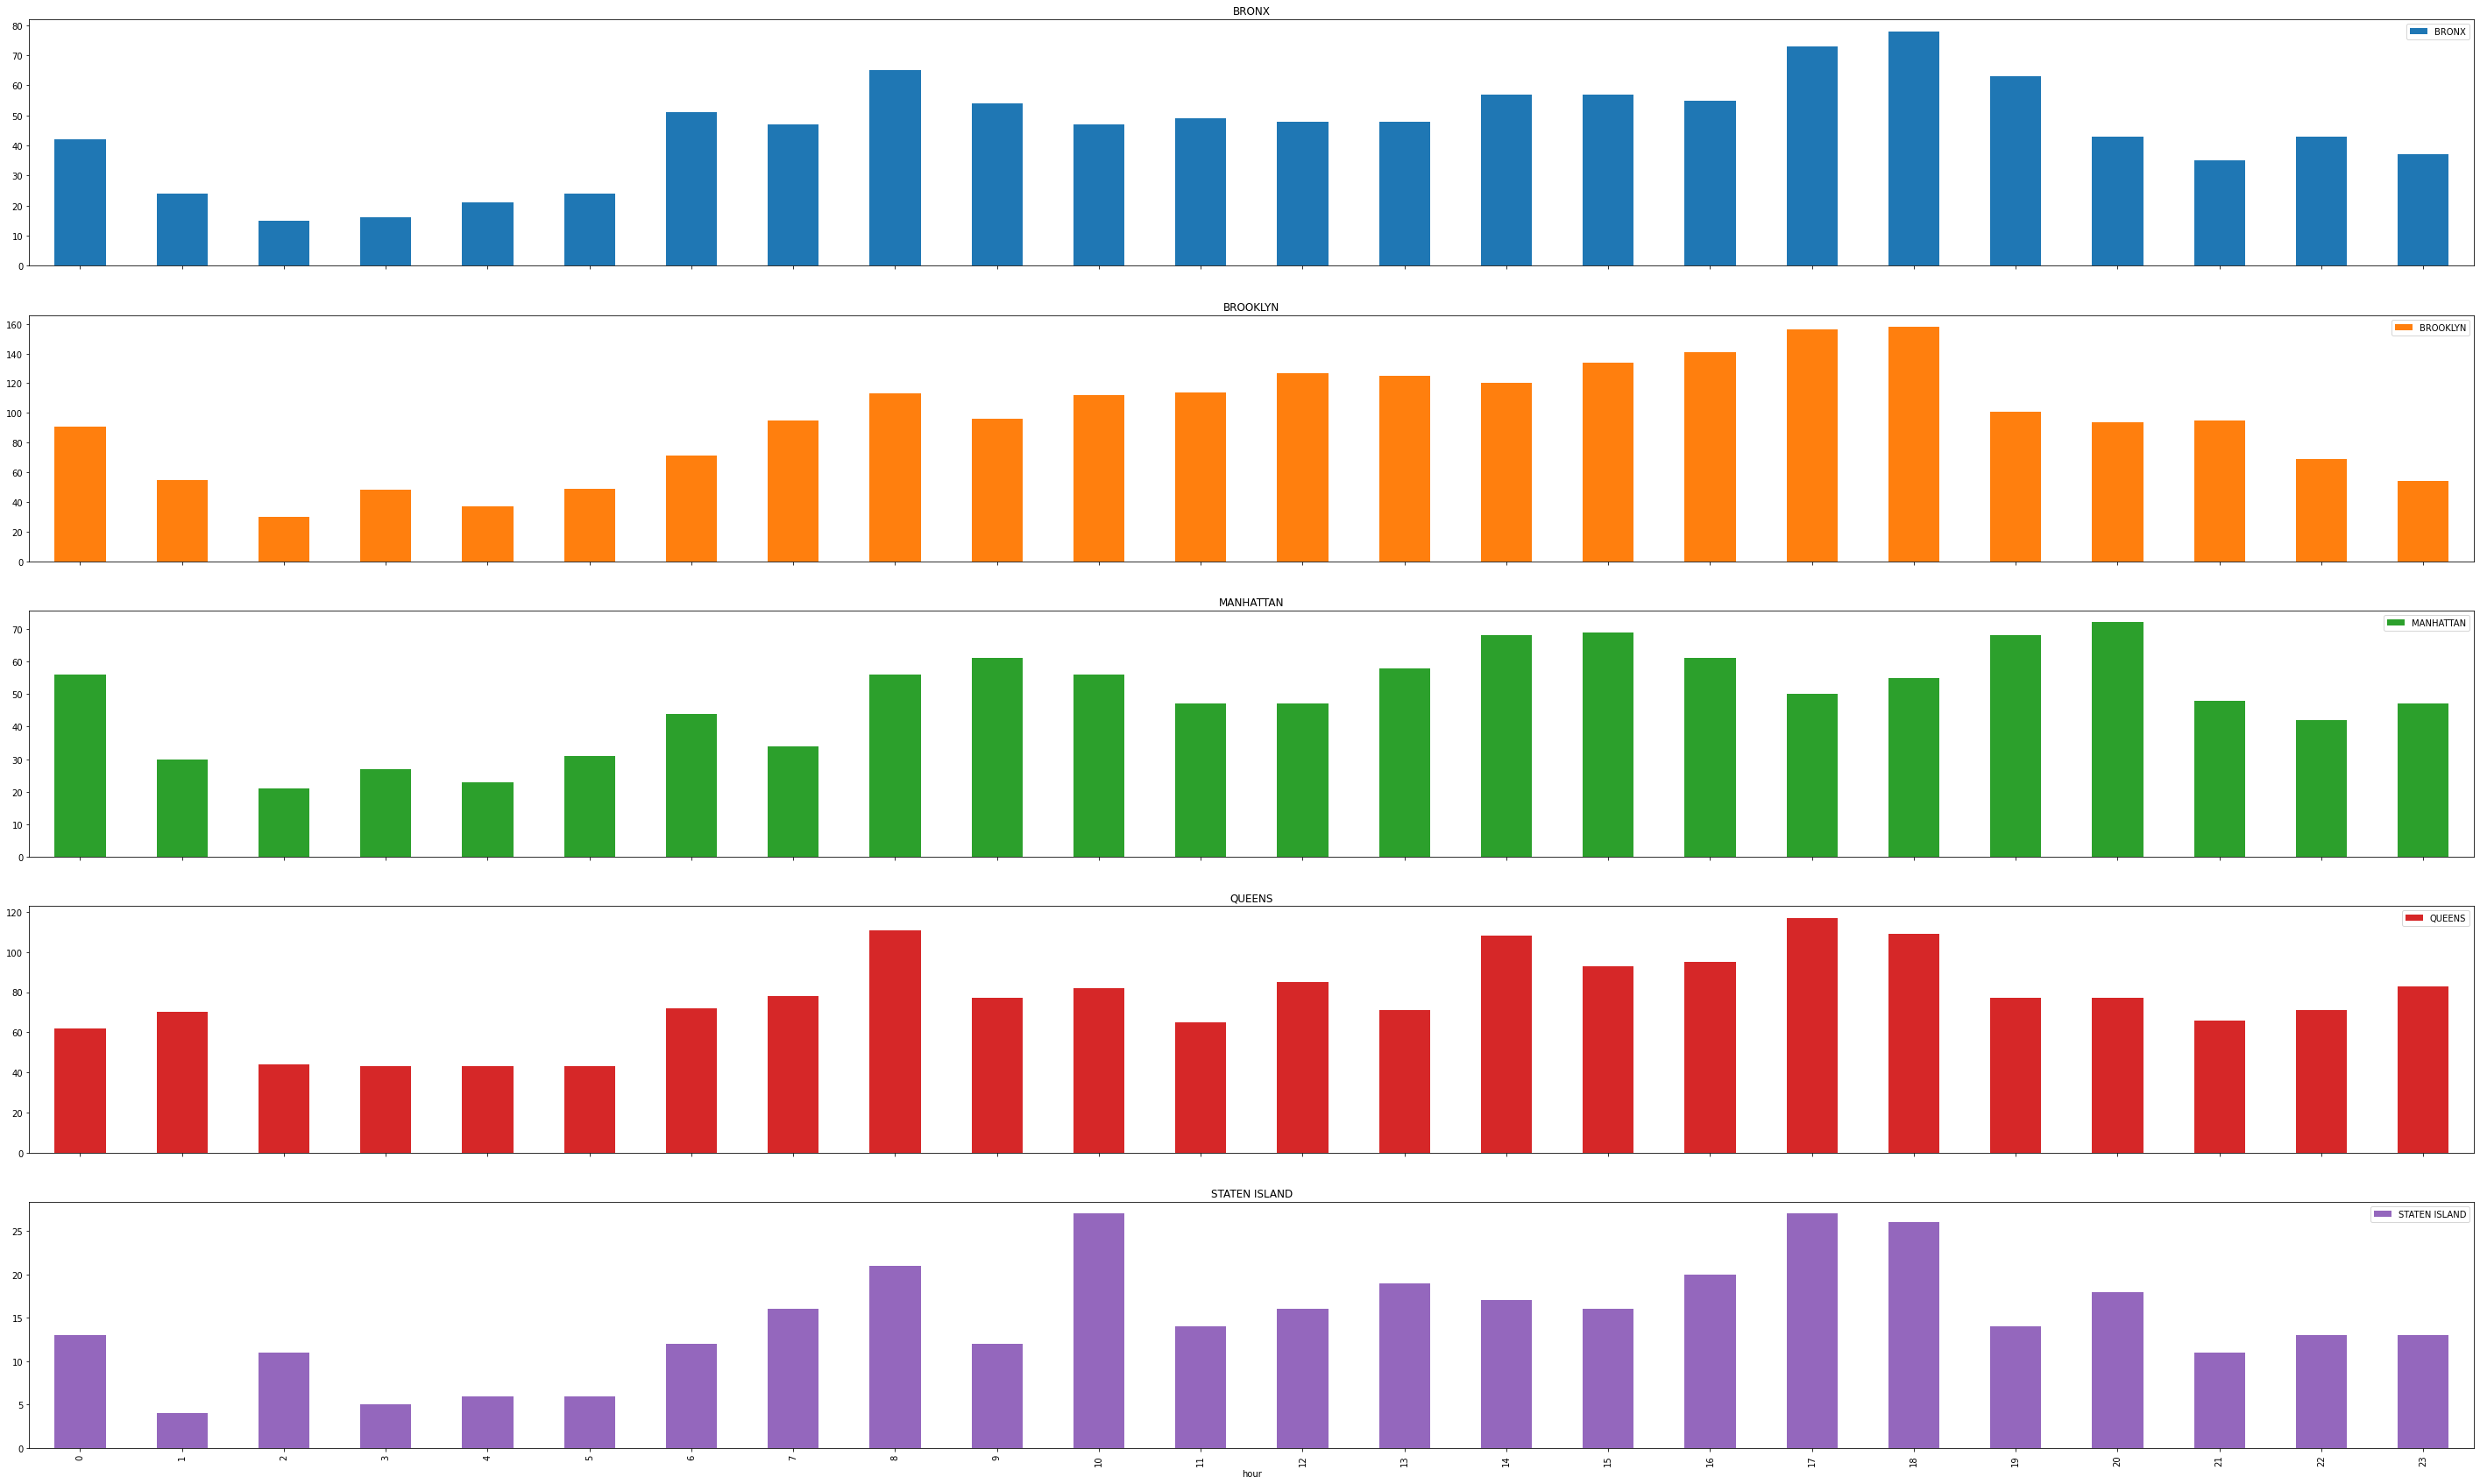

In [74]:
# Plot it by borough
hour_by_borough = jan23c.groupby(['hour','BOROUGH']).size().unstack(fill_value=0)
hour_by_borough.plot(kind='bar', subplots=True, layout=(5, 1),figsize=(50, 30))
plt.show()

In [115]:
# question 3 
import folium

In [129]:
# define a function to add a marker for each row in the DataFrame
def add_marker(row):
    if not pd.isna(row['LATITUDE']) and not pd.isna(row['LONGITUDE']):
        
        folium.CircleMarker(location=[row['LATITUDE'], row['LONGITUDE']],
        radius=0.1,weight=1).add_to(nyc_map)


# Create a map object centered on NYC
nyc_map = folium.Map(location=[40.769737, -73.91244], zoom_start=14)
# apply the function to each row in the DataFrame
jan23c.apply(add_marker, axis=1)

# display the map
nyc_map

In [120]:
# question 4
# Create a new variable injury.
jan23c['injury'] = jan23['NUMBER OF PERSONS INJURED'].\
    apply(lambda x: 1 if x >= 1 else 0)

# Create the cross table
cross_tab = pd.crosstab(jan23c['injury'], jan23c['BOROUGH'])

# Perform the chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(cross_tab)

"""
The p-value is less than 0.05, we could reject the null hypothesis that the two 
variables are not associated. The reults suggest that injury and BOROUGH are associated.
"""
print('Chi-squared statistic:', chi2)
print('P-value:', p)

Chi-squared statistic: 17.616976797947302
P-value: 0.0014659669427738832


In [159]:
# question 5
import sqlite3

# I download simple_db.sqlite and then create a connection to the database
conn = sqlite3.connect('data/simple_db.sqlite')

# execute a query and load the results into a pandas dataframe
zipdb = pd.read_sql_query("SELECT * from simple_zipcode", conn)

# close the database connection
conn.close()

In [150]:
# tried to merge but having error, so I check the type of the columns
print(type(zipdb['zipcode'][0]))
print(type(jan23c['ZIP CODE'][0]))

<class 'str'>
<class 'numpy.float64'>


In [152]:
# change the type of zipcode from str to float64
zipdb['zipcode'] = zipdb['zipcode'].astype('float64')

In [158]:
merged_df = pd.merge(jan23c, zipdb, how='left', left_on='ZIP CODE', right_on='zipcode')
merged_df

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0     01/01/2023      14:38        NaN       NaN        NaN        NaN   
1     01/01/2023       8:04        NaN       NaN        NaN        NaN   
2     01/01/2023      18:05        NaN       NaN        NaN        NaN   
3     01/01/2023      23:45     QUEENS   11103.0  40.769737 -73.912440   
4     01/01/2023       4:50      BRONX   10462.0  40.830555 -73.850720   
...          ...        ...        ...       ...        ...        ...   
7184  01/31/2023      20:31        NaN       NaN        NaN        NaN   
7185  01/31/2023       6:30  MANHATTAN   10035.0  40.801495 -73.934400   
7186  01/31/2023      14:20      BRONX   10457.0  40.846207 -73.897385   
7187  01/31/2023       0:35   BROOKLYN   11211.0  40.719760 -73.944760   
7188  01/31/2023      16:58   BROOKLYN   11203.0  40.655940 -73.941480   

                     LOCATION                   ON STREET NAME  \
0                         NaN  BROOKLYN QUEENS EXPRESSWAY RAMP   
1                         NaN                NASSAU EXPRESSWAY   
2                         NaN                        10 AVENUE   
3      (40.769737, -73.91244)                ASTORIA BOULEVARD   
4      (40.830555, -73.85072)               CASTLE HILL AVENUE   
...                       ...                              ...   
7184                      NaN                  LONGWOOD AVENUE   
7185    (40.801495, -73.9344)                              NaN   
7186  (40.846207, -73.897385)                              NaN   
7187    (40.71976, -73.94476)       BROOKLYN QUEENS EXPRESSWAY   
7188    (40.65594, -73.94148)                              NaN   

     CROSS STREET NAME            OFF STREET NAME  ...  land_area_in_sqmi  \
0                  NaN                        NaN  ...                NaN   
1                  NaN                        NaN  ...                NaN   
2            11 AVENUE                        NaN  ...                NaN   
3            37 STREET                        NaN  ...               0.71   
4      EAST 177 STREET                        NaN  ...               1.48   
...                ...                        ...  ...                ...   
7184  LAFAYETTE AVENUE                        NaN  ...                NaN   
7185               NaN         2400      2 AVENUE  ...               1.40   
7186               NaN  1880      BATHGATE AVENUE  ...               1.06   
7187               NaN                        NaN  ...               2.30   
7188               NaN  470       CLARKSON AVENUE  ...               2.15   

      water_area_in_sqmi  housing_units  occupied_housing_units  \
0                    NaN            NaN                     NaN   
1                    NaN            NaN                     NaN   
2                    NaN            NaN                     NaN   
3                   0.00        18518.0                 16890.0   
4                   0.00        31331.0                 29855.0   
...                  ...            ...                     ...   
7184                 NaN            NaN                     NaN   
7185                0.00        13935.0                 12775.0   
7186                0.00        24364.0                 22873.0   
7187                0.07        37180.0                 33489.0   
7188                0.00        28087.0                 26420.0   

      median_home_value  median_household_income  bounds_west  bounds_east  \
0                   NaN                      NaN          NaN          NaN   
1                   NaN                      NaN          NaN          NaN   
2                   NaN                      NaN          NaN          NaN   
3              648900.0                  55129.0   -73.922832   -73.902025   
4              271300.0                  45864.0   -73.871906   -73.839955   
...                 ...                      ...          ...          ...   
7184                NaN                      NaN

In [160]:
merged_df.to_csv('data/merged.csv', index=False)

In [190]:
# question 6 
# Fit the logistic regression model
import statsmodels.formula.api as smf

logit_model = smf.glm(formula = 'injury ~ hour + median_home_value + \
                     occupied_housing_units', data = merged_df,
                     family = sm.families.Binomial())
logit = logit_model.fit()

"""
Print the model summary. From the results, we could see that all three covariates are 
statistically significant, which means that there are associations between these predictors
and the outcome. The coefficents represent the change in the log-odds of the outcome for a 
one-unit change in the predictor variable, holding all other variables constant. However only
0.9%  of the variation in the outcome variable is explained by the predictors included in the 
model. This suggests that there may be other important predictors that are not included in the 
model.
"""
print(logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 injury   No. Observations:                 6672
Model:                            GLM   Df Residuals:                     6668
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4416.6
Date:                Fri, 17 Feb 2023   Deviance:                       8833.2
Time:                        11:55:18   Pearson chi2:                 6.67e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.008856
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [191]:
# check the odds rations out of curiosity
import statsmodels.api as sm
import numpy as np
coef = logit.params
odds_ratio = np.exp(coef)
# Print the results
print('Coefficients:\n', coef)
print('\nOdds ratios:\n', odds_ratio)

Coefficients:
 Intercept                -7.748075e-01
hour                      2.843275e-02
median_home_value        -3.750290e-07
occupied_housing_units    6.389348e-06
dtype: float64

Odds ratios:
 Intercept                 0.460792
hour                      1.028841
median_home_value         1.000000
occupied_housing_units    1.000006
dtype: float64
